In [1]:
import sys
print(sys.version)

3.7.0 (v3.7.0:1bf9cc5093, Jun 26 2018, 23:26:24) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
sns.set_style("dark")
sns.set_palette(sns.color_palette("BuGn_r"))
import statsmodels.api as sm

In [6]:
# Load crude oil dataset
df_oil = pd.read_csv("../data/ravenpack/crude_oil_all.csv")

In [7]:
print(set(df_oil.ENTITY_NAME))
print(df_oil.info())

{'Crude Oil'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106960 entries, 0 to 106959
Data columns (total 36 columns):
TIMESTAMP_UTC           106960 non-null object
RPNA_DATE_UTC           106960 non-null int64
RPNA_TIME_UTC           106960 non-null object
RP_ENTITY_ID            106960 non-null object
ENTITY_TYPE             106960 non-null object
ENTITY_NAME             106960 non-null object
POSITION_NAME           0 non-null float64
RP_POSITION_ID          0 non-null float64
COUNTRY_CODE            106960 non-null object
RELEVANCE               106960 non-null int64
TOPIC                   106960 non-null object
GROUP                   106960 non-null object
TYPE                    106960 non-null object
SUB_TYPE                100266 non-null object
PROPERTY                21422 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                106960 non-null object
ESS                     106960 non-null int64
AE

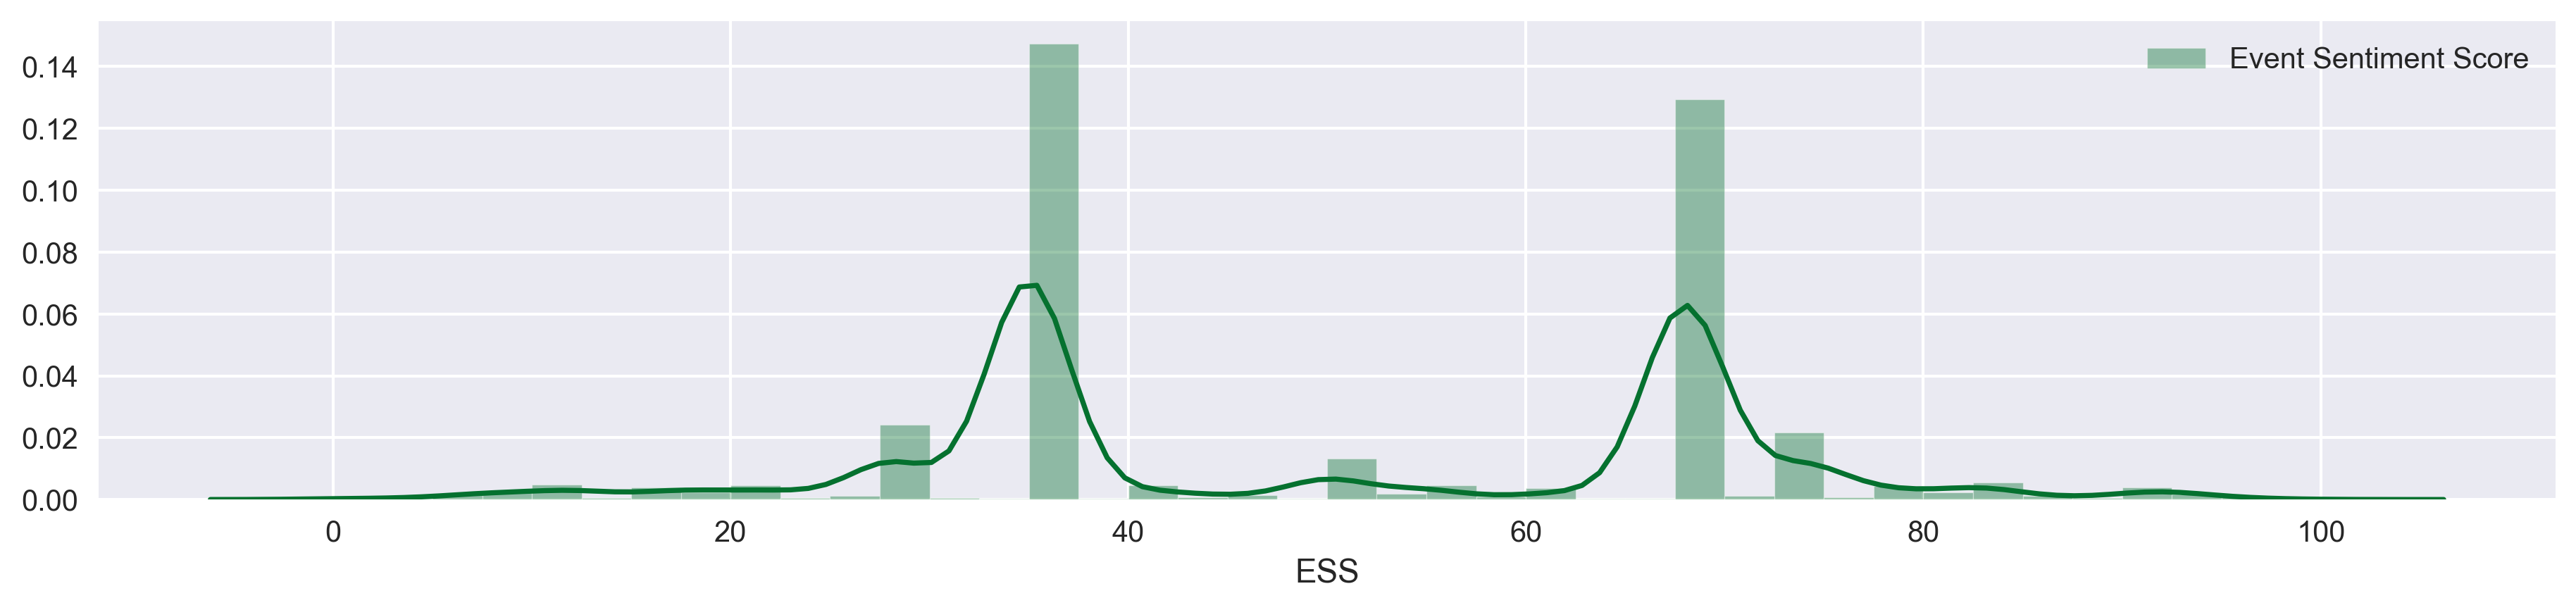

In [14]:
plt.rcParams["figure.figsize"] = (15, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True
sns.distplot(df_oil.ESS, bins=40, kde=True, label="Event Sentiment Score")
plt.legend()
plt.show()

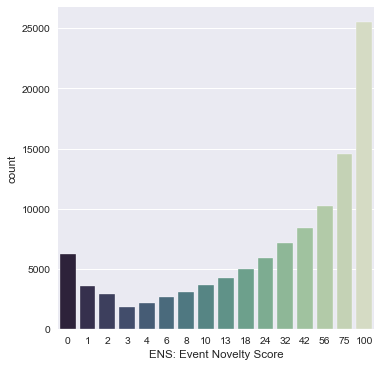

In [15]:
plt.rcParams["figure.dpi"] = 75
color = sns.cubehelix_palette(16, start=.5, rot=-.75, reverse=True)
chart = sns.catplot(x="ENS", kind="count", data=df_oil, palette=color)
chart.set_xlabels("ENS: Event Novelty Score")
chart.savefig("eda_figures/crude_oil/{}.png".format("ENS"))
plt.show()

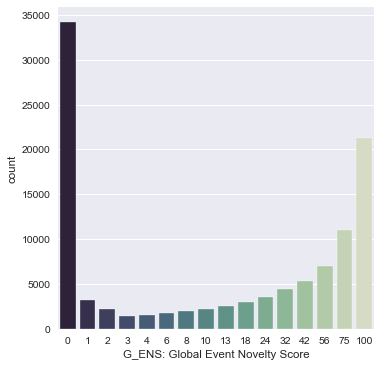

In [17]:
plt.rcParams["figure.dpi"] = 75
chart = sns.catplot(x="G_ENS", kind="count", data=df_oil, palette=color)
chart.set_xlabels("G_ENS: Global Event Novelty Score")
chart.savefig("eda_figures/crude_oil/{}.png".format("G_ENS"))
plt.show()

In [22]:
# up sample (aggregate) to daily level.
daily_mean_ess = pd.DataFrame(df_oil.groupby("RPNA_DATE_UTC").mean()["ESS"])
daily_sum_ess = pd.DataFrame(df_oil.groupby("RPNA_DATE_UTC").sum()["ESS"])
daily_size = pd.DataFrame(df_oil.groupby("RPNA_DATE_UTC").size())

df_daily = pd.concat([daily_mean_ess, daily_sum_ess, daily_size], axis=1)
df_daily.columns = ["MEAN_ESS", "TOTAL_ESS", "NUM_EVENTS"]
# Format the datetime index
df_daily.index = pd.to_datetime(daily_mean_ess.index, format="%Y%m%d")

In [23]:
df_daily.index = pd.to_datetime(daily_mean_ess.index, format="%Y%m%d")
daily_idx=pd.to_datetime(daily_mean_ess.index, format="%Y%m%d")
daily.index = daily_idx
daily.head()

,MEAN_ESS,TOTAL_ESS,NUM_EVENTS
RPNA_DATE_UTC,,,
2000-01-01,50.0,100,2
2000-01-03,68.0,68,1
2000-01-04,60.5,363,6
2000-01-05,35.0,35,1
2000-01-06,41.0,123,3


In [55]:
plot_objects = {
    "Average Daily ESS": daily.MEAN_ESS,
    "Log Total Daily ESS": np.log(daily.TOTAL_ESS),
    "Number of Daily Report": daily.NUM_EVENTS
}

In [56]:
[x.replace(" ", "_") for x in plot_objects.keys()]

['Average_Daily_ESS', 'Log_Total_Daily_ESS', 'Number_of_Daily_Report']

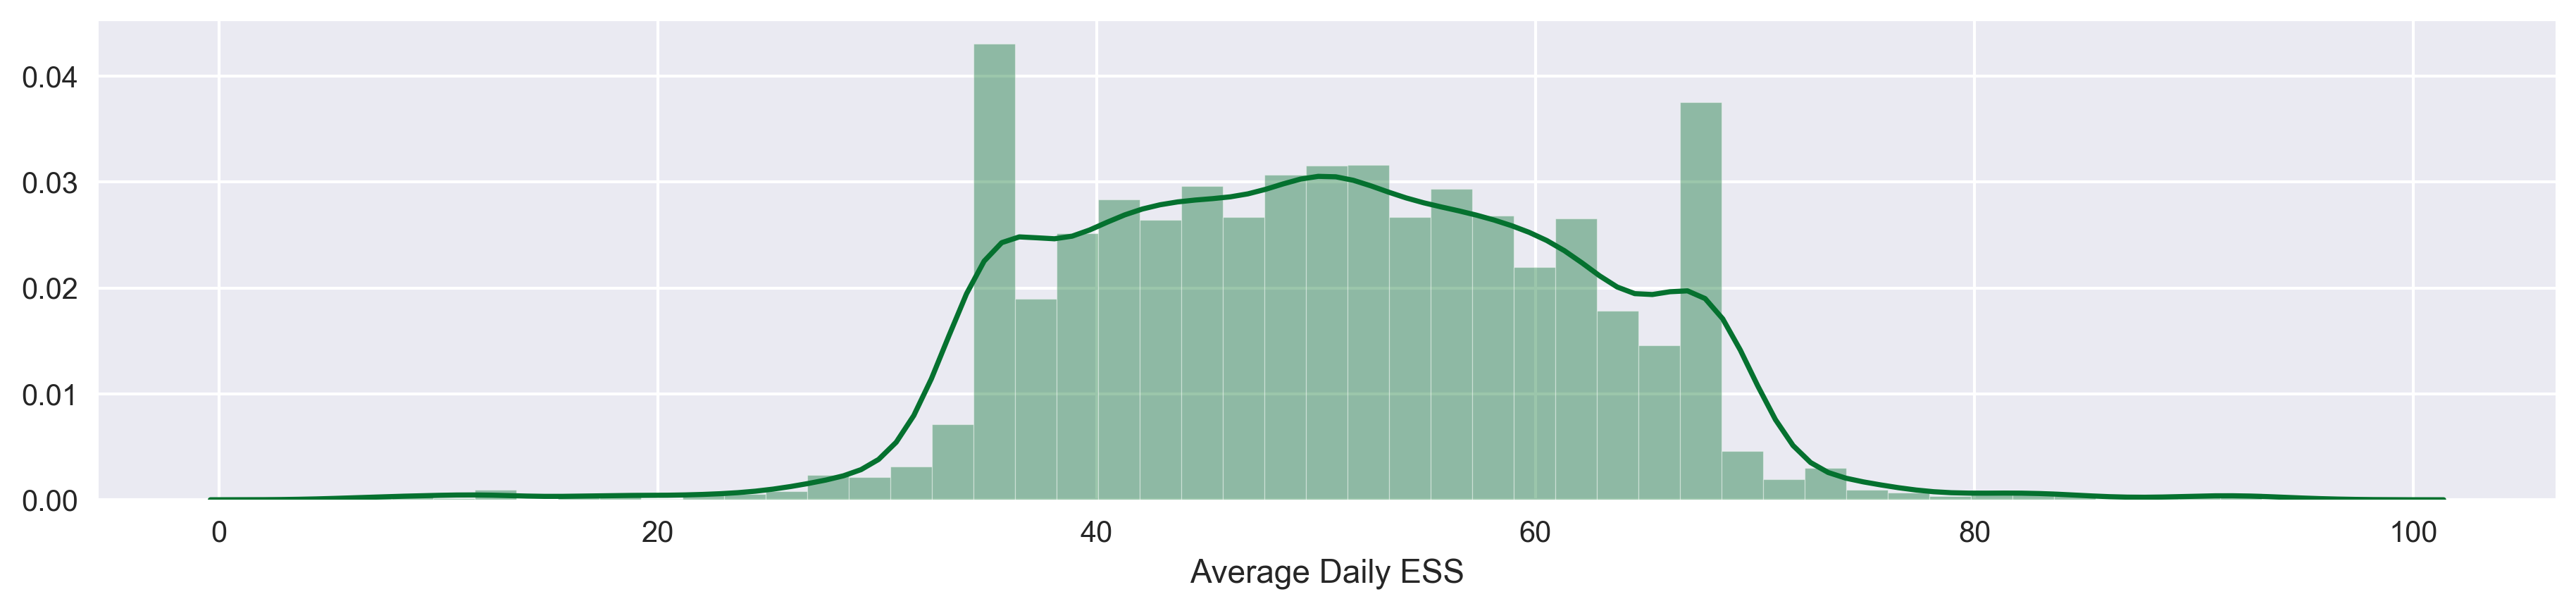

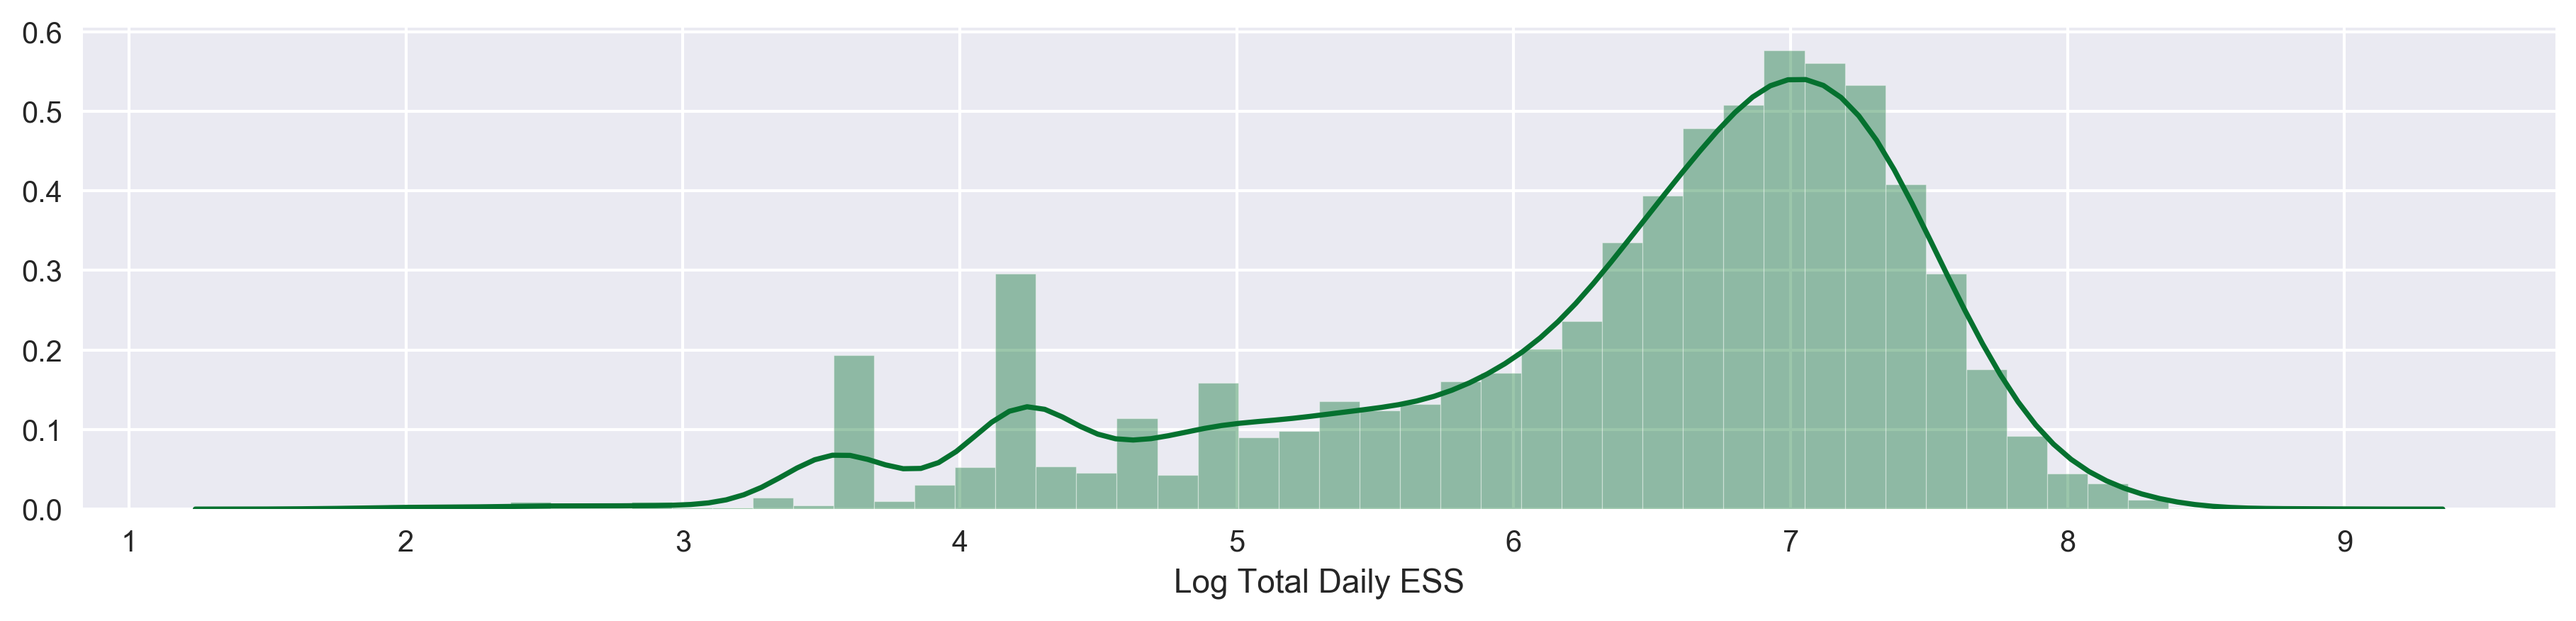

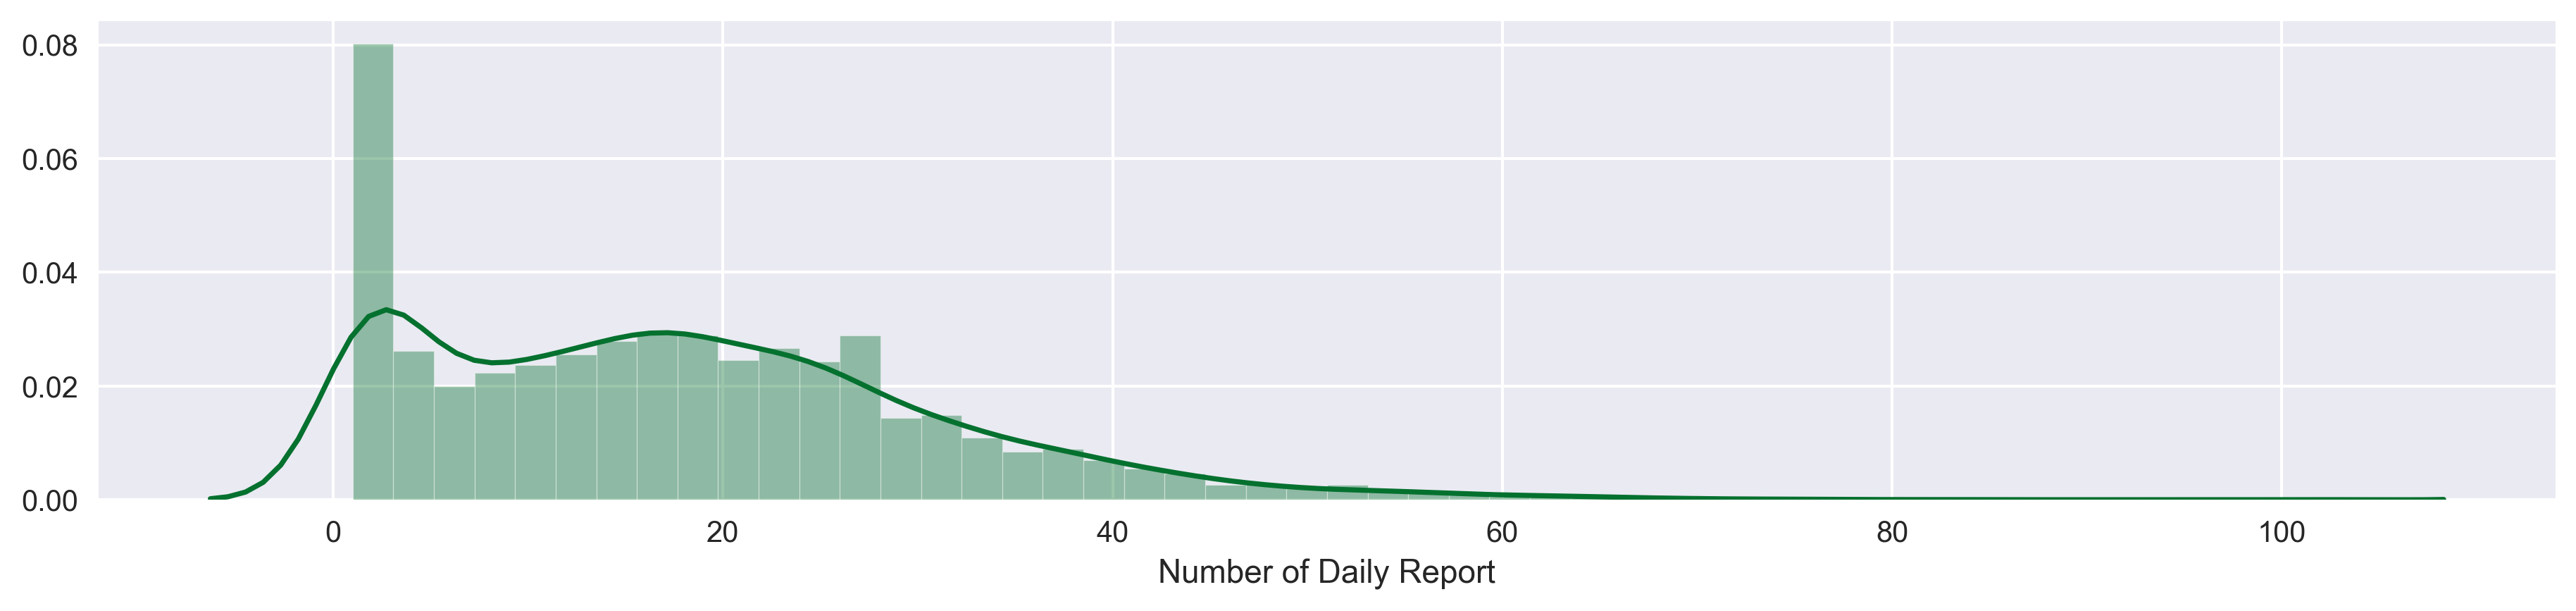

In [57]:
for k, v in plot_objects.items():
    sns.distplot(v, axlabel=k)
    plt.savefig("eda_figures/crude_oil/{}.png".format(k.replace(" ", "_")))
    plt.grid(True)
    plt.show()

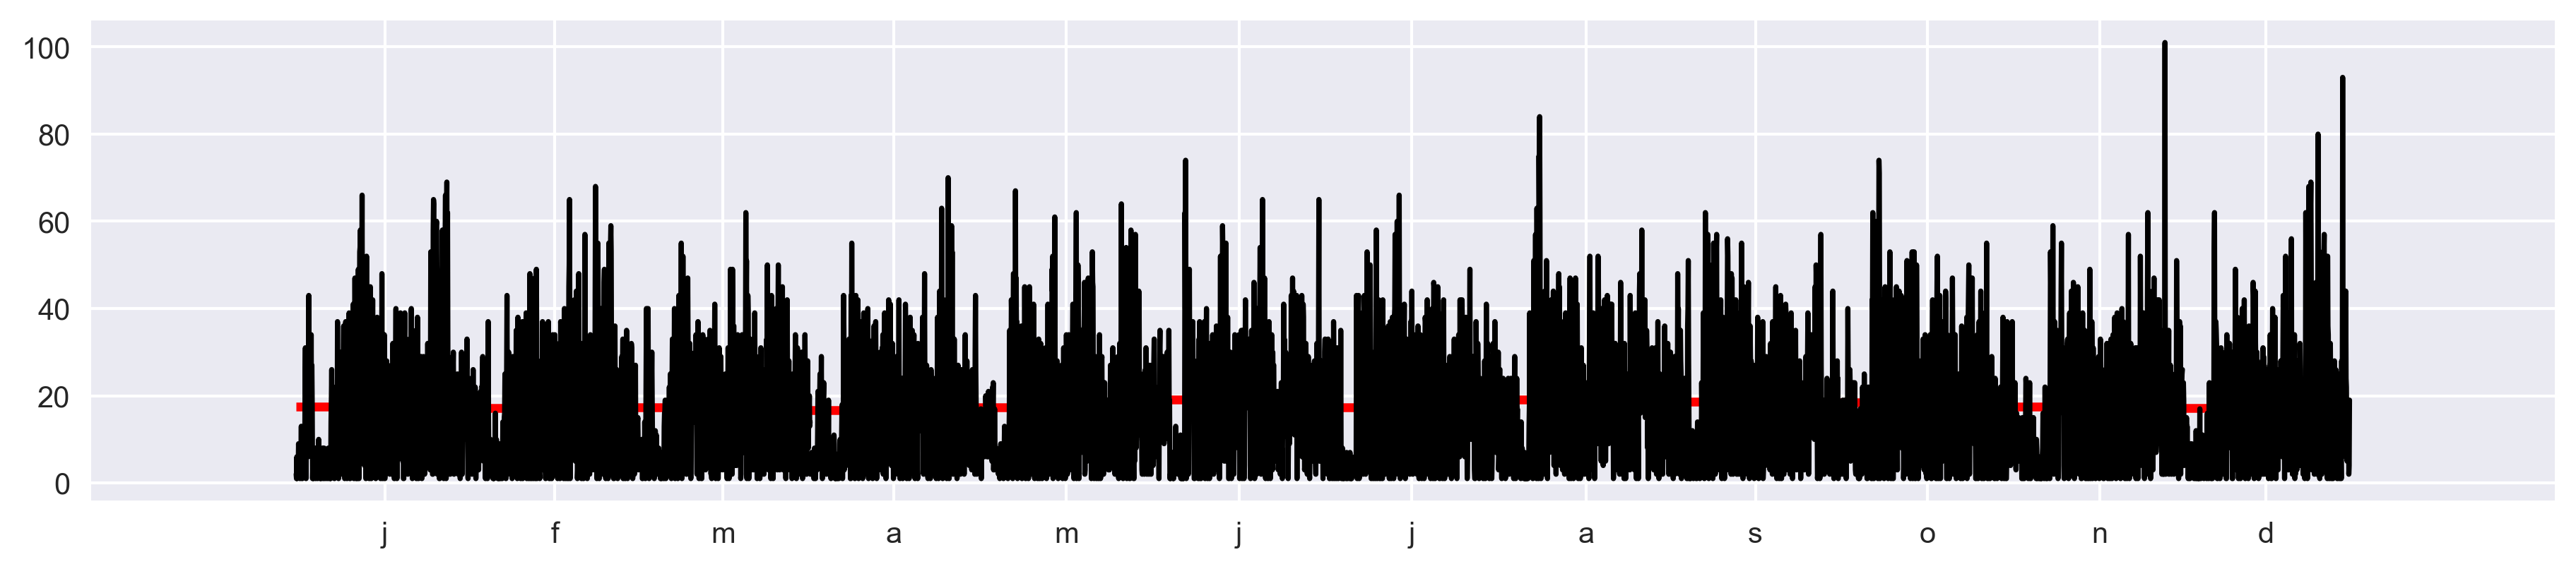

In [58]:
sm.tsa.graphics.month_plot(daily.NUM_EVENTS.values, dates=daily.index)
plt.show()

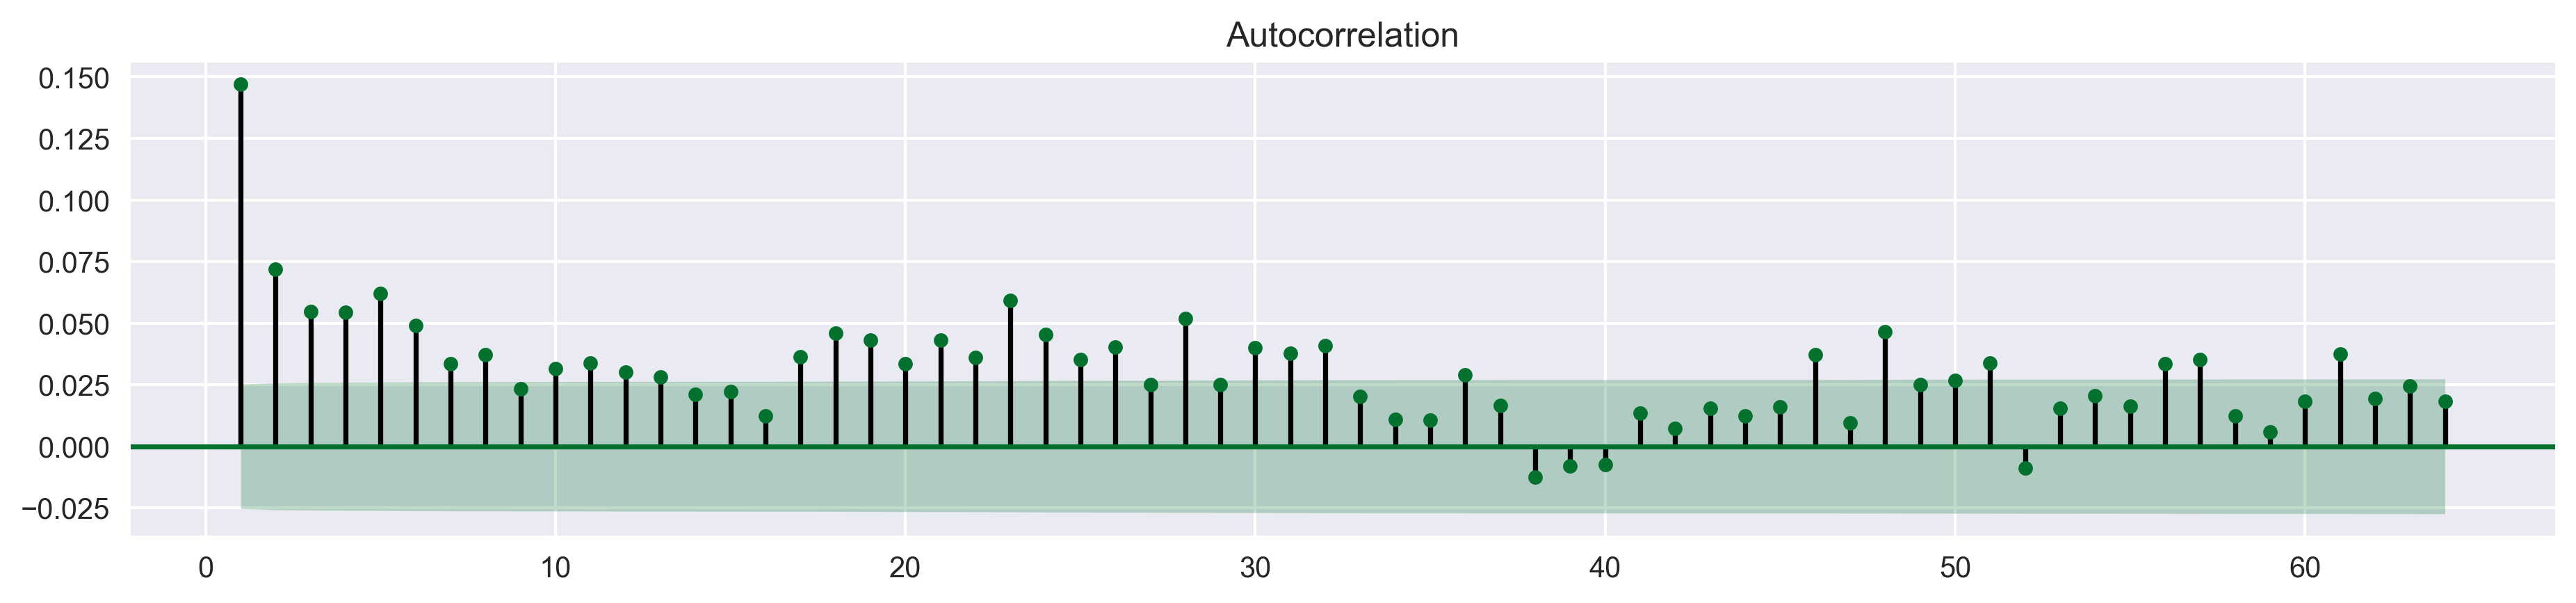

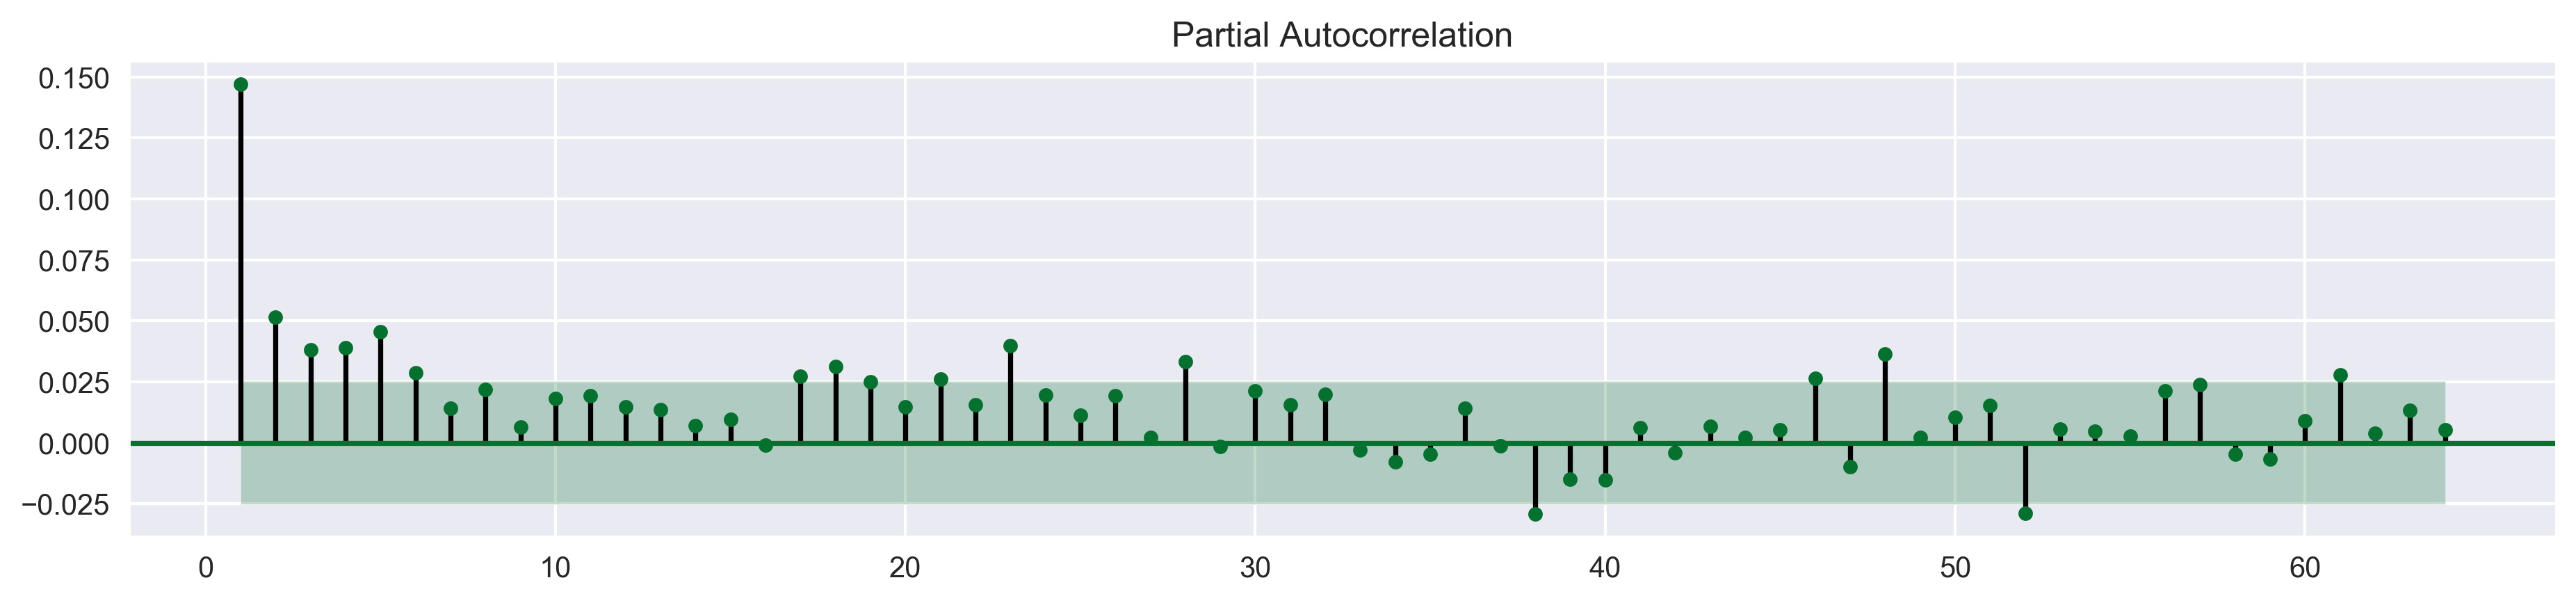

In [71]:
series = daily.MEAN_ESS
sm.tsa.graphics.plot_acf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("ACF_MEAN_ESS_L30"))
plt.show()
sm.tsa.graphics.plot_pacf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("PACF_MEAN_ESS_L30"))
plt.show()

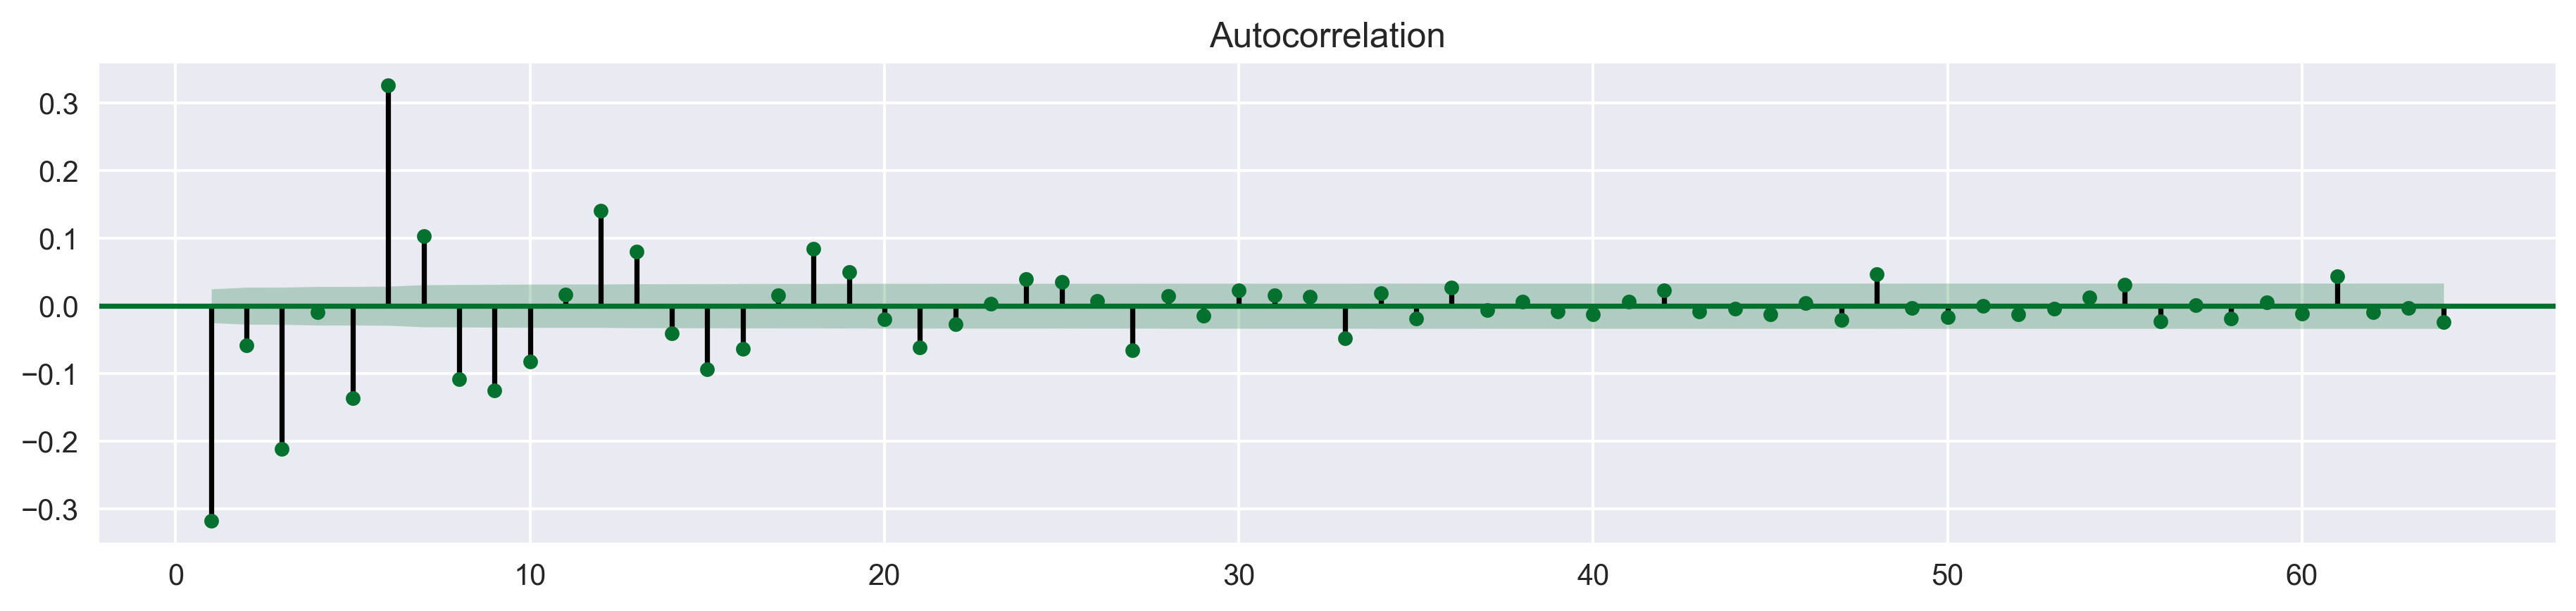

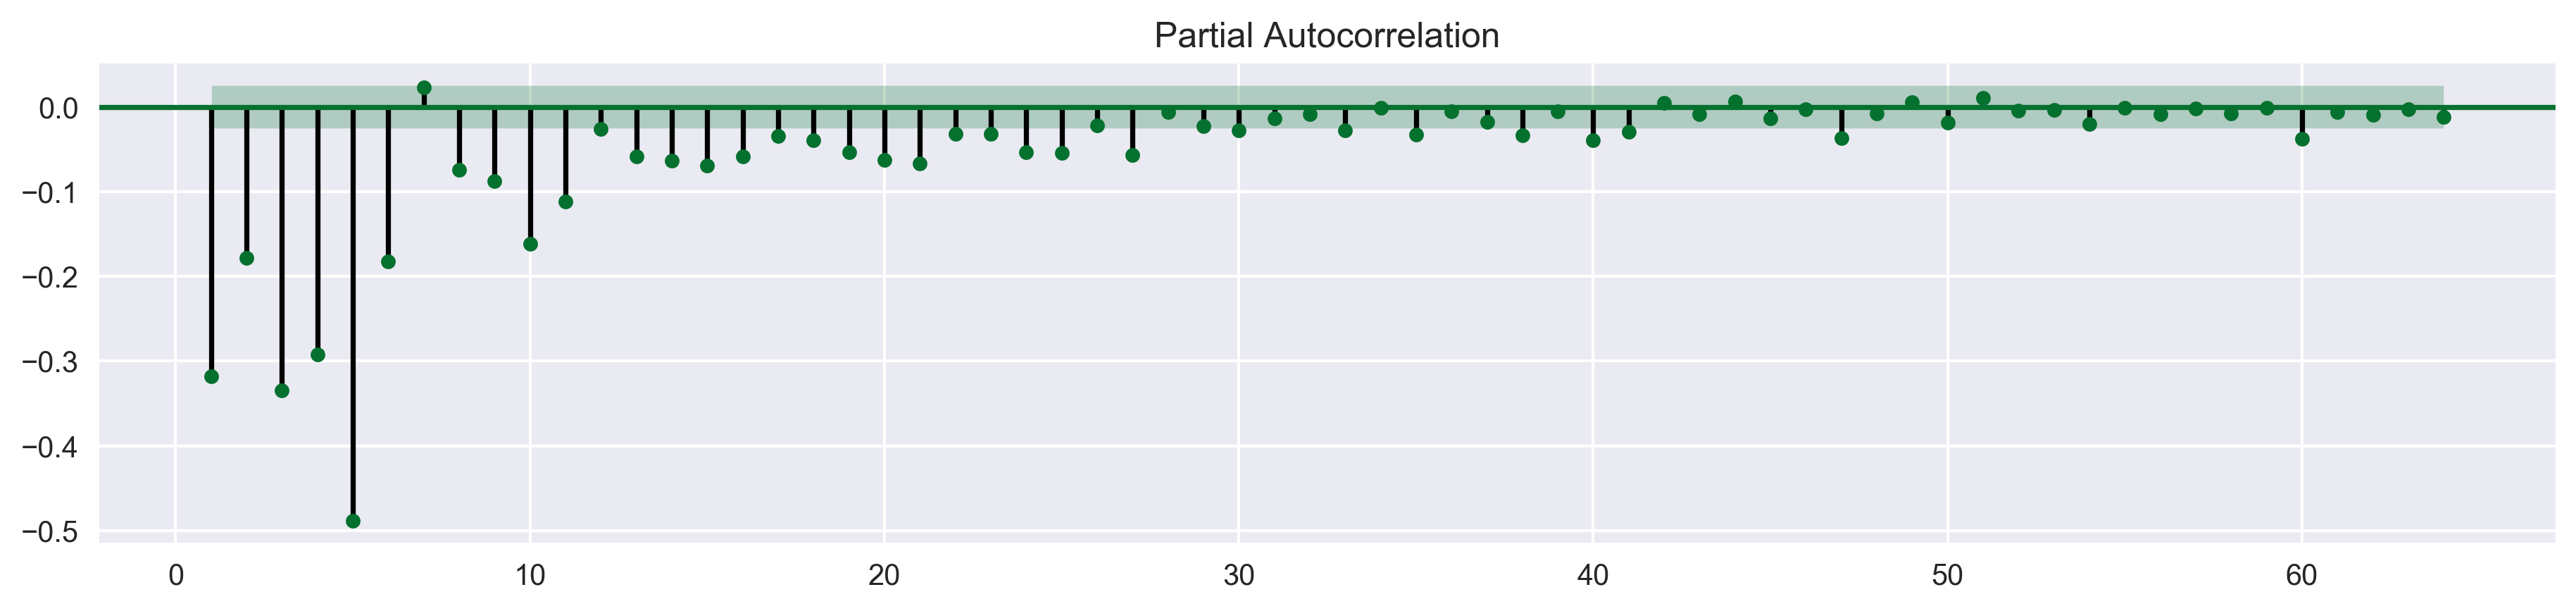

In [72]:
series = np.log(daily.TOTAL_ESS).diff().dropna()
sm.tsa.graphics.plot_acf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("ACF_MEAN_ESS_L30"))
plt.show()
sm.tsa.graphics.plot_pacf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("PACF_MEAN_ESS_L30"))
plt.show()

In [74]:
day_counts = daily.groupby(daily.index.day_name())["NUM_EVENTS"].sum()

In [75]:
day_counts = pd.DataFrame(day_counts)
day_counts["DAY"] = day_counts.index
day_counts

,NUM_EVENTS,DAY
RPNA_DATE_UTC,,
Friday,17031,Friday
Monday,17763,Monday
Saturday,756,Saturday
Sunday,1275,Sunday
Thursday,20143,Thursday
Tuesday,21269,Tuesday
Wednesday,28723,Wednesday


<Figure size 3000x1500 with 0 Axes>

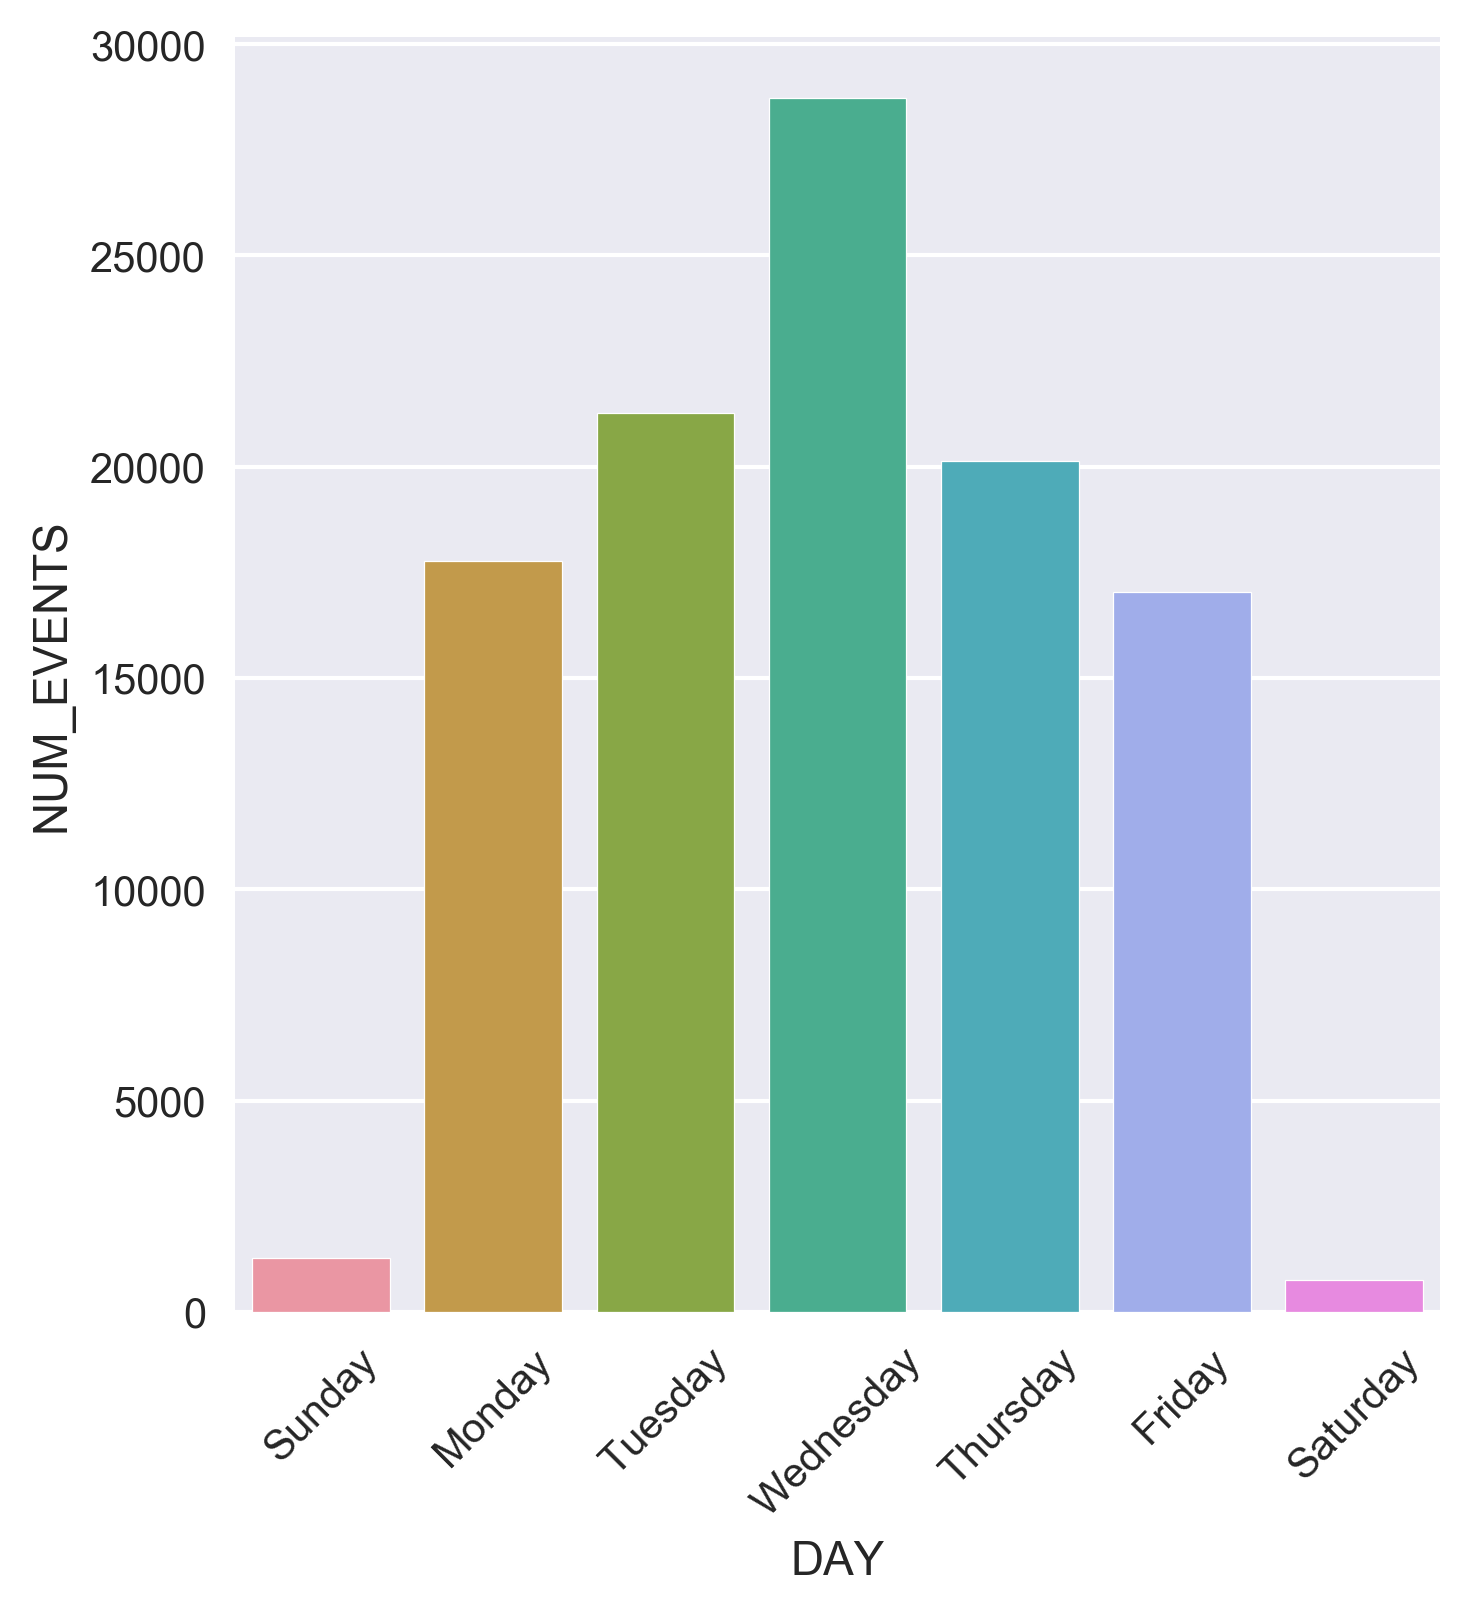

In [77]:
plt.figure(figsize=(10,5))
chart = sns.catplot(x="DAY", y="NUM_EVENTS", kind="bar",
            data=day_counts,
            order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
chart.set_xticklabels(rotation=45)
# chart.savefig("eda_figures/crude_oil/{}.png".format("Count_Days"))
plt.show()